<a href="https://colab.research.google.com/github/rakin000/predictive-maintenance-vinternship/blob/main/predictive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!cd predictive-maintenance-vinternship

In [54]:
!git clone https://github.com/rakin000/predictive-maintenance-vinternship

fatal: destination path 'predictive-maintenance-vinternship' already exists and is not an empty directory.


In [55]:
import torch,random,sklearn
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

In [56]:
fd = pd.read_excel("Group 3.xlsx")
fd[:10]
fd.to_csv("dataset.csv")

df = fd.drop(columns =['wpump', 'radiator', 'exvalve', 'acmotor', 'id'])

print(fd.columns)
print(df.describe().transpose())
print(df[:10])
print(df.corr()['bearings'].abs().sort_values())
print(f"True = {sum([x==1 for x in df['bearings']])}, False ={sum([x==0 for x in df['bearings']])}")

Index(['id', 'rpm', 'motor_power', 'torque', 'outlet_pressure_bar', 'air_flow',
       'noise_db', 'outlet_temp', 'wpump_outlet_press', 'water_inlet_temp',
       'water_outlet_temp', 'wpump_power', 'water_flow', 'oilpump_power',
       'oil_tank_temp', 'gaccx', 'gaccy', 'gaccz', 'haccx', 'haccy', 'haccz',
       'bearings', 'wpump', 'radiator', 'exvalve', 'acmotor'],
      dtype='object')
                      count         mean          std          min  \
rpm                  1000.0  1499.516000   707.681915   480.000000   
motor_power          1000.0  6984.877371  4269.277571  1402.424603   
torque               1000.0    49.186120    18.706750    13.222197   
outlet_pressure_bar  1000.0     4.054049     1.862761     1.000000   
air_flow             1000.0   754.673930   442.743491    95.098952   
noise_db             1000.0    53.412121     8.055363    39.879017   
outlet_temp          1000.0   118.855110    19.120181    76.902822   
wpump_outlet_press   1000.0     2.799610     0.

In [57]:
#upscale 
df_majority = df[df['bearings']==0]
df_minority = df[df['bearings']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=800,    # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print(df_upsampled['bearings'].value_counts())

df = df_upsampled

0    800
1    800
Name: bearings, dtype: int64


In [58]:
from sklearn.model_selection import train_test_split

dftrain, dftest = train_test_split(df, test_size=0.2)

In [59]:
Xtrdf = dftrain.drop(columns = ['bearings']) 
Ytrdf = dftrain['bearings']
Xtestdf = dftest.drop(columns = ['bearings']) 
Ytestdf = dftest['bearings']

In [60]:
Xtrdf[:10]

,rpm,motor_power,torque,outlet_pressure_bar,air_flow,noise_db,outlet_temp,wpump_outlet_press,water_inlet_temp,water_outlet_temp,wpump_power,water_flow,oilpump_power,oil_tank_temp,gaccx,gaccy,gaccz,haccx,haccy,haccz
198,516,4675.909203,87.311337,7.308,95.175558,42.076366,108.719208,2.822538,66.497746,84.926550,217.721972,58.562061,300.553446,46.214832,0.704706,0.451638,7.888006,1.197129,1.406556,5.553659
915,2497,16596.851920,64.967891,6.286,1482.540546,60.030317,159.579368,3.870596,123.077939,130.307539,227.707295,45.489101,300.354128,46.616987,0.558864,0.330382,5.596425,1.048635,1.314462,4.277474
969,2496,6399.217361,28.805576,2.201,488.658662,61.663355,125.059882,3.139232,87.121407,106.464941,220.297731,58.193287,300.469521,46.271513,0.559566,0.357581,2.143265,1.052609,1.331293,2.554329
454,1504,5467.532394,35.243903,3.035,904.438504,59.322942,105.750087,2.804246,75.564286,80.007375,218.220074,58.450431,300.046989,46.162905,0.582687,0.386817,2.738117,1.069461,1.319105,2.854210
245,1003,2521.825400,28.281815,1.617,610.825277,51.780332,90.845360,1.961843,55.583342,69.321990,218.868299,58.920597,300.697412,45.945621,0.615180,0.309705,2.222286,1.100964,1.351172,2.655840
43,517,1648.947124,35.285489,1.441,307.153738,45.865455,79.076018,2.092670,45.935891,58.420513,217.377447,59.114801,300.669738,45.863446,0.712882,0.399976,2.731062,1.204587,1.377269,2.974956
471,1488,8877.086304,57.697424,5.359,889.956404,57.900649,119.092692,2.638452,81.202848,100.691948,222.075265,58.485536,301.154071,46.277264,0.576214,0.315398,4.653585,1.069202,1.285357,3.814771
677,2003,17696.189470,88.092317,8.385,1186.621522,71.085611,142.649501,3.618494,104.668311,117.296203,225.892850,57.749366,299.718152,46.497232,0.567994,0.350366,8.739534,1.054226,1.370243,5.877374
247,1005,3152.229100,31.030610,2.240,607.349532,52.163885,95.548721,2.153428,58.868789,73.655925,215.228605,58.853368,300.403594,46.003842,0.616547,0.335825,2.475472,1.106589,1.323806,2.764592
67,491,3539.191167,72.950716,5.364,301.714179,50.064551,97.291327,2.220246,60.017426,72.498678,217.172928,58.691599,299.980733,46.062542,0.716128,0.397609,5.451996,1.211358,1.421129,4.365640


In [61]:
Ytrdf[:10]

198    0
915    0
969    0
454    1
245    1
43     1
471    1
677    1
247    1
67     1
Name: bearings, dtype: int64

In [62]:
Xtr = torch.tensor(Xtrdf[Xtrdf.columns].values) #,dtype=torch.float64)
Ytr = torch.tensor(Ytrdf.values).reshape(-1,1)
Xtest = torch.tensor(Xtestdf[Xtrdf.columns].values) #,dtype=torch.float64)
Ytest = torch.tensor(Ytestdf.values).reshape(-1,1)

In [63]:
# Standard Scalar 
xmean = Xtr.mean(0,keepdims=True) 
xstd = Xtr.std(0,keepdims=True)
Xtr = (Xtr - xmean) / xstd 
Xtest = (Xtest - xmean)/ xstd

In [64]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class Relu:
  def __call__(self, x):
    self.out = torch.relu(x)
    return self.out
  def parameters(self):
    return []


class Sigmoid:
  def __call__(self, x):
    self.out = torch.sigmoid(x)
    return self.out
  def parameters(self):
    return []


def train(X,Y,n_feature,batch_size=32,max_iteration=10000,verbose=True,plot=False):
  stepi = []
  lossi = [] 
  
  for i in range(0,max_iteration):
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X,Y
    
    x = Xb 
    for layer in layers:
      x = layer(x)
    loss = F.binary_cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
      p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    if plot == True:
      stepi.append(i)
      lossi.append(loss.item())
  
    if plot == True: 
      plt.plot(stepi, lossi)



@torch.no_grad()
def loss_c(X,Y):
  for layer in layers:
      X = layer(X)
  loss = F.binary_cross_entropy(X,Y)
  return loss 
  

In [65]:
#initialize parameters 

n_feature = X.shape[1] # the dimensionality of the character embedding vectors
n_hidden1 = 60 # the number of neurons in the hidden layer of the MLP
n_hidden2 = 120 
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_feature, n_hidden1), Relu(),
  Linear(n_hidden1, n_hidden2), Relu(),
  Linear(n_hidden2, 1), Sigmoid(),
]

def eval(x):
  for layer in layers:
    x = layer(x)
  return x 
  
parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

8701


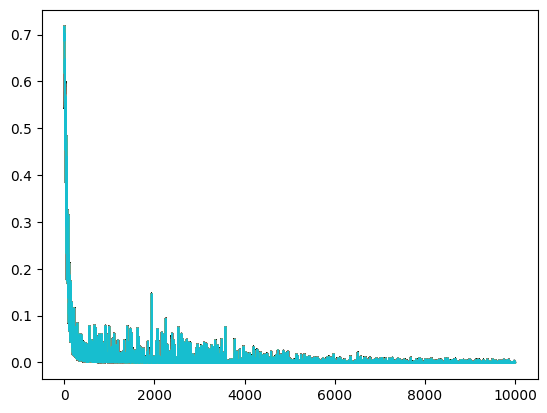

In [66]:
train(Xtr.float(),Ytr.float(),n_feature,plot=True)

In [67]:
print(f"Test loss={loss_c(Xtest.float(),Ytest.float())}")
print(f"Train loss={loss_c(Xtr.float(),Ytr.float())}")

Test loss=0.0034830670338124037
Train loss=0.00037661424721591175


In [68]:
# rpm: 1499.52
# motor_power: 6984.88
# torque: 49.186
# outlet_pressure_bar: 4.06
# air_flow: 754.67
# noise_db: 53.41
# outlet_temp: 118.86
# wpump_outlet_press: 2.80
# water_inlet_temp: 83.02
# water_outlet_temp: 96.64
# wpump_power: 222.19
# water_flow: 53.71
# oilpump_power: 300.48
# oil_tank_temp: 46.24
# gaccx: 0.60
# gaccy: 0.35
# gaccz: 3.92
# haccx: 1.10
# haccy: 1.35
# haccz: 3.50
x_in = torch.tensor([1499.52, 6984.88, 49.186, 4.06, 754.67, 53.41, 118.86, 2.80, 83.02, 96.64, 222.19, 53.71, 300.48, 46.24,0.60, 0.35, 3.92, 1.10, 1.35, 3.50])
x_in = (x_in-xmean)/xstd
x_in = x_in.float()
for layer in layers:
  x_in = layer(x_in)
x_in.data

tensor([[2.4433e-05]])

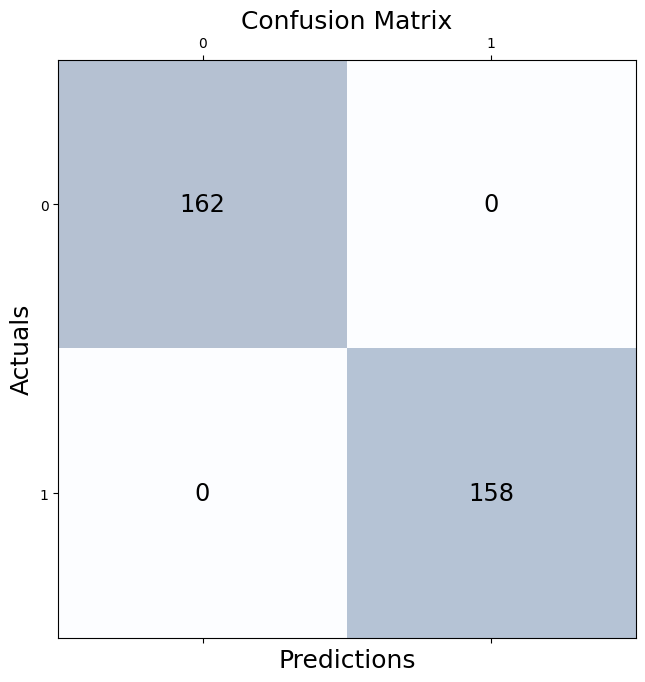

In [70]:
y_pred = eval(Xtest.float())
conf_matrix = confusion_matrix(y_true=torch.round(Ytest).detach().numpy(), y_pred=torch.round(y_pred).detach().numpy())
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()